## Spark Context

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
sc.stop()  # this is how to stop the context (sometimes useful to release memory in Spark)

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Simple RDDs, map, collect, and take

In [4]:
# start with an easy handmade dataset with temperature data in Celsius
# the goal:  convert this data to Kelvin (recall that 0 C = 273.15 K)
temperature_C = [5, 6, 6, 10, 15, 20, 19, 18]  # right now this data is local.  It is here on the "driver"

# create an RDD (resilient distributed dataset)
temperature_C_rdd = sc.parallelize(temperature_C)  # this pushes data out to worker machines

def convert_celsius_to_kelvin(tempC):
    return tempC + 273.15

temperature_K_rdd = temperature_C_rdd.map(convert_celsius_to_kelvin)

In [5]:
temperature_K_rdd.collect() # bring all results back to driver

[278.15, 279.15, 279.15, 283.15, 288.15, 293.15, 292.15, 291.15]

In [6]:
# for large datasets .collect() will try to pull too much data back.  To inspect just a few use .take() instead
temperature_K_rdd.take(3)

[278.15, 279.15, 279.15]

In [7]:
# Using a lambda instead could've cut out a few lines of code
temperature_K_rdd = temperature_C_rdd.map(lambda tempC: tempC + 273.15)

In [8]:
temperature_K_rdd.take(3)

[278.15, 279.15, 279.15]

## Reduce

In [9]:
kid_ages = [6, 8, 2, 9, 10, 13, 7, 4]

# create an RDD
kid_ages_rdd = sc.parallelize(kid_ages)

sum_kid_ages = kid_ages_rdd.reduce(lambda x, y: x+y)
sum_kid_ages

59

In [10]:
num_kids = kid_ages_rdd.count()
avg_kid_age = sum_kid_ages/num_kids
avg_kid_age

7.375

## Exercise

Suppose that RDDs did not come with the handy `.count()` function.  Can you think of a way, using `map` and `reduce`, to count the number of elements in an RDD?  For example, count the number of kids.

In [11]:
kid_indicator_rdd = kid_ages_rdd.map(lambda x: 1)
kid_indicator_rdd.take(3)

[1, 1, 1]

In [12]:
num_kids = kid_indicator_rdd.reduce(lambda x, y: x+y)
num_kids

8

## Partitions

*Partitioning* is the process of distributing data across workers.  This allows workers to process in parallel.  The final results are then collated and combined.

Under the hood, each worker machine is subdivided into "executors".    Often 1 executor = 1 core.

You should have # partitions at LEAST equal to the total number of executors in your cluster, otherwise some executors will just sit idle.

Each partition is processed sequentially on a single executor.  There is one *task* per element in the partition.

In [13]:
# ASIDE:  string concatenation
strconcat = "hello" + "there"
print(strconcat)
strconcat = "hello" + " " + "there"
print(strconcat)

# converting numbers into strings
numstr = str(5.6)
print(numstr)

hellothere
hello there
5.6


In [14]:
# let's SEE partitioning by examining the ORDER in which reduce is applied
def visualize_combine(x, y):
    return "(" + str(x) + " " + str(y) + ")"

# test it
visualize_combine(5, 7)

'(5 7)'

In [15]:
visualize_combine(5, visualize_combine(7, 10))

'(5 (7 10))'

In [16]:
visualize_combine(visualize_combine(5, 7), 10)

'((5 7) 10)'

In [17]:
# let's reduce an RDD that has only a single partition
kid_ages_rdd.reduce(visualize_combine)

'(((((((6 8) 2) 9) 10) 13) 7) 4)'

In [18]:
# let's partition the kid ages into 2 partitions
kid_ages_rdd2 = sc.parallelize(kid_ages, 2)  # second argument specifies number of partitions

In [19]:
# let's reduce an RDD that has 2 partitions
kid_ages_rdd2.reduce(visualize_combine)

'((((6 8) 2) 9) (((10 13) 7) 4))'

RESULT IS DIFFERENT DEPENDING ON HOW MANY PARTITIONS YOU SPECIFY!!!

We cannot live in a world where different number of partitions gives different results.  Because of this, `reduce` only works when the combine operation is *associative* (in the mathematical sense).

((A + B) + C) = (A + (B + C))

Other problem:  ORDERING is not guaranteed.  Say you want to `reduce` 3 elements A, B, and C.  Suppose each element is the result of a previous computation.

If A and C are ready before B then `reduce` might combine them in this order:  ((A C) B)
If A and B are ready before C then `reduce` might combine them in this order:  ((A B) C)
...and so on

This also won't be consistent run after run unless the combine operation is *commutative* (in the mathematical sense)

(A B) = (B A)

## Spark is LAZY

### Transformations

`map` is an example of a *transformation* on an RDD.  **Transformations** operate on an RDD and produce a new RDD.

Recall that, in regular Python (operating on a `list`), `map` is LAZY.  No computation is actually performed until you explicitly ask for the final result.

Similarly, all Spark transformations (including Spark's version of `map`) are also lazy.  Nothing is done until absolutely necessary.

Transformations can be chained together (the input to a transformation might depend on the output of one or more previous transformation(s)). This builds a so-called dependency **DAG (directed acyclic graph)** of transformations.

### Actions

**Actions** are operations performed on an RDD that produce a result (e.g. a single number) and bring it back to the driver (BTW this Jupyter notebook IS the "driver").

`reduce` is a great example of an action.

Actions trigger the processing of the dependency DAG (the previous unprocessed transformations).

Other actions that you've already seen:

- .collect()    fetches all elements of the RDD and returns to driver
- .take(n)    fetches the first n elements of the RDD and returns to driver
- .count()    counts how many elements are in the RDD and returns that result to driver

In [20]:
# recall regular Python (operating on lists) is also LAZY (when programming in the functional style)
data = [1.6, 2.4, 7.8, 4.6, 2.3]

newdata_lazy = map(lambda x: x+1, data)
newdata_lazy

In [21]:
# I can force the "action" by explicitly converting to a list
newdata = list(newdata_lazy)
newdata

[2.6, 3.4, 8.8, 5.6, 3.3]

In [22]:
# Let's look at the same idea, but in Spark
data_rdd = sc.parallelize(data)  # push data to workers to create RDD

newdata_rdd = data_rdd.map(lambda x: x+1)  # NOTHING has been done at this point

In [23]:
# perform the .collect() action to bring the modified list back to driver
newdata = newdata_rdd.collect()
newdata

[2.6, 3.4, 8.8, 5.6, 3.3]

### More complicated example of creating a DAG of transformations, then trigger with an action

In [24]:
import numpy as np

# generate some random samples from the Laplace distribution (remember your stock returns!)
location = 0.0
scale = 1.0
data = np.random.laplace(location, scale, 1000)
data

array([ 4.68392855e+00, -8.74989992e-01,  1.31834533e-01,  2.40502824e-01,
        1.47518497e+00, -1.43997527e+00, -3.83936109e-01, -1.52959124e+00,
        1.21662077e+00,  5.99404928e-01, -1.08998371e+00, -3.71343319e-01,
       -2.67584804e+00, -1.07844308e+00,  7.55193764e-01,  8.99163958e-01,
        7.37223316e-01, -3.93237287e-01, -1.06506254e+00,  6.33339891e-01,
        2.73912297e+00, -2.70876221e+00,  8.38662448e-01, -1.42038960e+00,
        1.97667963e+00, -6.51449961e-02, -6.47555706e-01, -1.60160573e-01,
        1.33150307e+00,  1.75560120e-01,  7.67687460e-01,  1.33445991e+00,
       -1.62423087e+00, -1.99205304e+00,  2.60706962e+00, -3.41018172e+00,
        7.98059775e-01,  1.03740460e-01,  1.60760107e+00,  7.28033918e-01,
        5.08587797e-01, -1.90302571e+00, -8.79372988e-01, -4.24084426e-01,
        1.01644411e+00, -3.92948710e-01, -2.64586916e-01,  2.01994980e+00,
        1.04898043e+00,  4.13005911e-01,  7.29526718e-01,  3.02277713e-01,
        2.09641478e-01, -

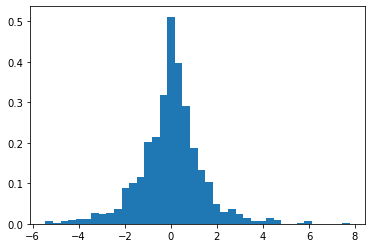

In [25]:
# let's plot a histogram
import matplotlib.pyplot as plt

bins = 40
plt.hist(data, bins, density=True)
plt.show()

In [26]:
# Remember:  numpy arrays are very much like "beefed up" lists
# We can actually parallelize them to RDDs just like lists

data_rdd = sc.parallelize(data, 4)

In [27]:
# Let's filter our data for only POSITIVE stock returns (because I only like good news)
# .filter() is a transformation
filtered_data_rdd = data_rdd.filter(lambda x: x >= 0)

In [28]:
# Let's subsample to make the calculations go faster
# .sample() is a transformation
with_replacement = True
sample_fraction = 0.5

subsampled_data_rdd = filtered_data_rdd.sample(with_replacement, sample_fraction)

In [29]:
# If I want *exactly* reproducible results then must specify the random SEED (computers only really have PSEUDOrandom algorithms)
random_seed = 123
subsampled_data_rdd = filtered_data_rdd.sample(with_replacement, sample_fraction, random_seed)

In [30]:
# UP TO NOW NO WORK HAS BEEN DONE!!!  Only a DAG has been constructed

# Let's perform an action to trigger the DAG
# Let's count our data 
subsampled_data_rdd.count()

249

In [31]:
# Let's compute the standard deviation of my positive returns
# .stddev() is also an action.  It trigers the DAG above.
# Do you think Spark will recompute everything from the beginning?  Or is it smarter than that?
sigma = subsampled_data_rdd.stdev()
sigma

1.0553027393726273

In [32]:
# Let's collect all the data back and graph it
# .collect() is also an action
subsampled_data = subsampled_data_rdd.collect()

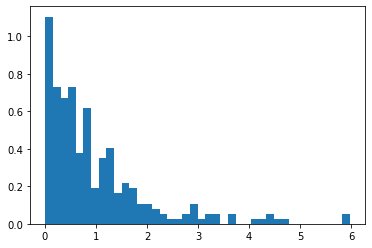

In [33]:
bins = 40
plt.hist(subsampled_data, bins, density=True)
plt.show()